In [ ]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from toy_datasets.rotational_dataset import make_dataset

In [ ]:
dataset = make_dataset(30, 120)

In [ ]:
dataset

### Need to give the raw data a steerable representation

In [9]:
class Complex:

    def __init__(self, r, theta):
        assert r >= 0
        self.r = r
        self.theta = theta % (np.pi*2)

    def __repr__(self):
        return f"{self.r}*exp[i {self.theta}]"

    @property
    def euc_form(self):
        # Python natively uses Euclidean form
        return self.r*np.exp(1j*self.theta)

    @property
    def real(self):
        return self.r * np.cos(self.theta)

    @property
    def im(self):
        return self.r * np.sin(self.theta)

    @classmethod
    def from_euc(cls, z):
        r = abs(z)
        theta = np.arctan2(z.imag, z.real)

        return cls(r, theta)

In [10]:
# Do this into complex space - nicer to work with for computing shift properties

def fourier_transform_point_function(z: Complex, precision):
    """Analytically obtain the fourier transform of a dirac function on S1 """
    indexes = np.arange(-precision, precision + 1)
    c = [
        z.r*np.exp(-1j*k*z.theta) for k in indexes # cast to euc form so python can do operations
    ]
    scaler = 1/np.pi
    c = np.array(c) * scaler
    f_hat = np.column_stack((indexes, c))
    return f_hat

def inverse_transform(f_hat):
    k = f_hat[:, 0]
    c = f_hat[:, 1]

    scaler = 1/(2*np.pi)
    components = lambda x: c*np.exp(-k*x*1j)
    f = lambda x: scaler*components(x).sum()
    f = np.vectorize(f)
    return f

C:\Users\niksm\Documents\CodeForUni\venvs\transformer_invariants\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Argument shifted: \n dual domain')

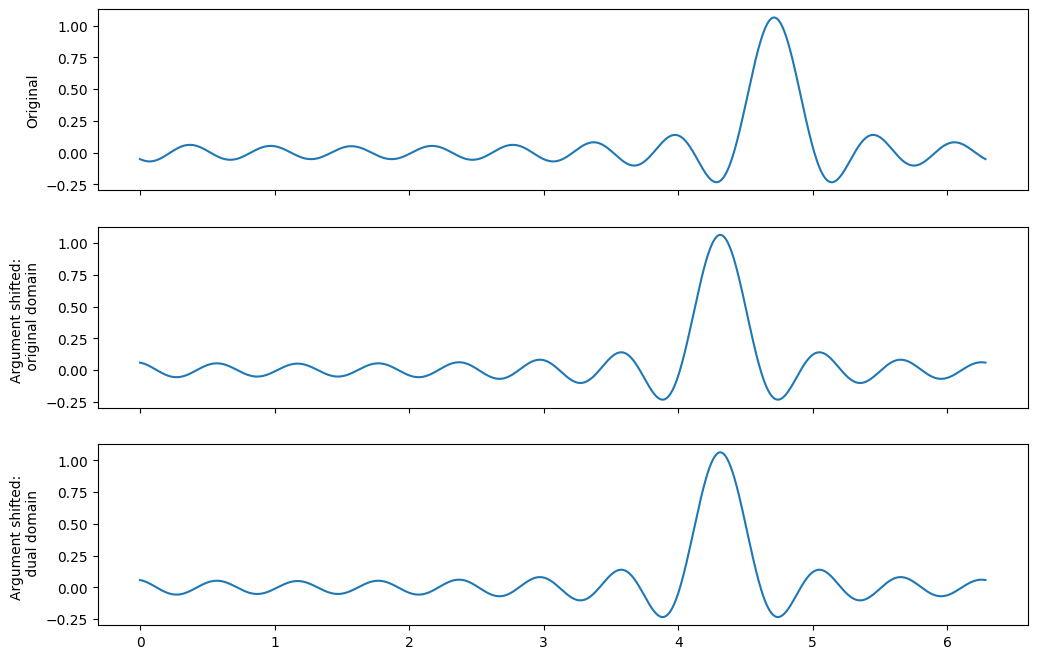

In [11]:
fig, ax = plt.subplots(3, figsize=[12,8], sharex=True)

# adjust the main plot to make room for the sliders
xs = np.linspace(0, 2*np.pi, 1000)
N = 10
m = 4

init_r, init_theta = 1.0, np.pi/2
offset_theta = 1/N*m # shift has to be k-dependent or you are mixing groups

# Plot the original function
z_orig = Complex(init_r, init_theta)
z_hat_orig = fourier_transform_point_function(z_orig, N)
z_hat_hat_orig = inverse_transform(z_hat_orig)

ax[0].plot(xs, z_hat_hat_orig(xs))
ax[0].set_ylabel('Original')

# Perform the shift in the original domain.

z_shift_in = Complex(init_r, init_theta + offset_theta)
z_hat_shift_in = fourier_transform_point_function(z_shift_in, N)
z_hat_hat_in = inverse_transform(z_hat_shift_in)

ax[1].plot(xs, z_hat_hat_in(xs))
ax[1].set_ylabel('Argument shifted: \n original domain')

# Perform the shift in the dual domain.
z_hat_shifted_out = z_hat_orig.copy()
shifter = np.exp(-1j*offset_theta*z_hat_shifted_out[:, 0]) # Where does this 2 come from??
z_hat_shifted_out[:, 1] *= shifter

z_hat_hat_shifted_out = inverse_transform(z_hat_shifted_out)
ax[2].plot(xs, z_hat_hat_shifted_out(xs))
ax[2].set_ylabel('Argument shifted: \n dual domain')

#### Now define a transformer that works on these

In [12]:
class AttentionBlock(torch.nn.Module):

    def __init__(self):
        super().__init__()

In [13]:
class Base_SE2_Transformer(torch.nn.Module):
    """An abstract class! Need to subclass to produce invariants """
    def __init__(self, attention_hidden_units):
        super().__init__()

        self.attention_calculator = torch.nn

    def get_num_invariant_dimensions(self):
        raise NotImplementedError("Implement on subclass")

    def forward(self, x, ys):
        raise NotImplementedError() # TODO

    def get_positional_invariants(self, coords_1, coords_2):
        raise NotImplementedError("Create a subclass to implement this!")

class Euclidean_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariant(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        return np.sqrt(x_diff**2 + y_diff**2)

    def get_num_invariant_dimensions(self):
        return 1

class FullyExpressive_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariants(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        angle_diff = theta2 - theta1
        return np.sqrt(x_diff**2 + y_diff**2), angle_diff


